In [1254]:
import pickle
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from sklearn.model_selection import train_test_split

In [1255]:
class Node:
    def __init__(self, predict_data, parent, left_child, right_child, 
                     label, mean, mse, samples, value, level, leaf=False):
        self.predict_data = predict_data
        self.parent = parent
        self.left_child = left_child
        self.right_child = right_child
        self.label = label
        self.mean = mean
        self.mse = mse
        self.samples = samples
        self.value = value
        self.level = level
        self.leaf = leaf
    def display(self):
        for i in range (0, self.level):
            print('|   ', end = '')
        print('|--- ', end = '')
        if self.leaf == False:
            print(self.label, '<=', self.mean)
        else:
            print('value: [', self.value, ']', sep='')
        if self.left_child != None:
            self.left_child.display()
        if self.right_child != None:
            for i in range (0, self.level):
                print('|   ', end = '')
            print('|--- ', end = '')
            print(self.label, '>', self.mean)
            self.right_child.display()
    
    def _display(self):
        for i in range (0, self.level):
            print('|   ', end = '')
        print('|--- ', end = '')
        if self.leaf == False:
            print(self.label, '<=', self.mean, end = ', ')
            print('mse =', self.mse, end = ', ')
            print('samples =', self.samples, end = ', ')
            print('value =', self.value)
        else:
            print('value: [', self.value, ']', sep='')
        if self.left_child != None:
            self.left_child.display()
        if self.right_child != None:
            for i in range (0, self.level):
                print('|   ', end = '')
            print('|--- ', end = '')
            print(self.label, '>', self.mean, end = ', ')
            print('mse =', self.mse, end = ', ')
            print('samples =', self.samples, end = ', ')
            print('value =', self.value)
            self.right_child.display()
    
    def set_left_child(self, left_child):
        self.left_child = left_child
    
    def set_right_child(self, right_child):
        self.right_child = right_child
    
    def predict(self, x_test_instance_dict, int_ml_task=0):
        if self.left_child != None and x_test_instance_dict[self.label] <= self.mean:
            return self.left_child.predict(x_test_instance_dict)
        elif self.right_child != None and x_test_instance_dict[self.label] > self.mean:
            return self.right_child.predict(x_test_instance_dict)
        else: #is a leaf
            if int_ml_task == 0:#'classification'
                return self.predict_data.value_counts().index[0]
            else:
                return self.predict_data.mean()
    
    def getKey(self):
        return str(self.label) + ' <= ' + str(self.mean)
    
    def getValue(self):
        if self.leaf:
            return self.predict_data.value_counts().index[0]
        else:
            return {self.getKey(): [self.left_child.getValue(), self.right_child.getValue()]}
    
    def isLeaf(self):
        return self.leaf
    
    def be_leaf(self): #turn to a leaf
        this_node = copy.copy(self)
        left_node = None
        right_node = None
        this_node.set_left_child(left_node)
        this_node.set_right_child(right_node)
        this_node.leaf = True
        return this_node
    
    def prune_by_level(self, max_depth):
        if self.leaf:
            return copy.copy(self)
        elif self.level == max_depth:
            return self.be_leaf()
        else:
            this_node = copy.copy(self)
            left_node = this_node.left_child.prune_by_level(max_depth)
            right_node = this_node.right_child.prune_by_level(max_depth)
            this_node.set_left_child(left_node)
            this_node.set_right_child(right_node)
            return this_node

In [1256]:
class DecisionTreeRegressor:
    def __init__(self, max_depth = 0, ml_task='classification'):
        self.data = None
        self.target = None
        self.max_depth = 0
        self.tree = None
        self.depth = 0
        self.max_depth = max_depth
        self.dict_tree = None
        self.ml_task = ml_task
        
    def fit(self, x_train, y_train):
        self.data = x_train
        self.target = y_train
        self.tree = self.build_tree(self.data, self.target, 0, None)
        self.dict_tree = self.build_dict(self.tree)
    
    def best_split(self, df, label, best_mse):
        print(df)
        #use to save best feature and its value easily
        best_feature = None
        best_value = None
        
        #use to drop features got only one unique
        drop_data_columns = []
        for feature in df.columns:
            df = df.dropna().sort_values(feature)
            if feature == label: continue
            if len(np.unique(df[feature])) == 1:
                drop_data_columns.append(feature)
                continue
            ### calculate moving average (MA), to split into left and right branch
            means = np.convolve(df[feature].unique(), np.ones(2), 'valid') / 2
            print(means)
            for val in means:
                left_y = df[df[feature] <= val]['Y'].values
                right_y = df[df[feature] > val]['Y'].values
                left_mean = np.mean(left_y)
                right_mean = np.mean(right_y)
                # Getting the left and right residuals 
                res_left = left_y - left_mean 
                res_right = right_y - right_mean
                # Concatenating the residuals 
                residuals = np.concatenate((res_left, res_right), axis=None)
                # Calculate mse when we split with this MA of this FEATURE
                mse_split = np.sum(residuals ** 2) / len(residuals)
                print(feature, val, mse_split)
                # Compare mse, take min
                if mse_split < best_mse:
                    best_feature = feature
                    best_value = val
                    best_mse = mse_split
                    print('*****')
        #print(best_feature)
        #print(best_value)
        #print(best_mse)
        #drop no need feature
        for feature in drop_data_columns:
            df = df.drop(columns = [feature])
        return df, best_feature, best_value
    
    def build_tree(self, data, target, level, parent):
        df = data.copy()
        df['Y'] = target
        
        #Calculate mse_base
        temp_y = (df['Y'] - np.mean(df['Y'])) ** 2
        mse_base = np.sum(temp_y) / len(df['Y'])
        
        #save value for node (just ignore these till create Node
        value = np.mean(df['Y'])
        samples = len(df['Y'])
        if len(df['Y'].unique()) == 1 or (self.max_depth != 0 and level >= self.max_depth):
            print('Making leaf:', round(mse_base, 3), samples, round(value, 3), len(df['Y'].unique()))
            print('###')
            print(df['Y'])
            print('###')
            return Node(df['Y'], parent, None, None, None, None, round(mse_base, 3), samples, round(value, 3), level, True)
        
        #'best' spliter    
        df, best_feature, best_value = self.best_split(df, 'Y', mse_base)
        if best_feature == None: return None
        else: self.depth = max(self.depth, level)
        subset_left = df[df[best_feature] <= best_value]
        subset_right = df[df[best_feature] > best_value]
        left_Node = None
        right_Node = None
        newNode = Node(df['Y'],
                        parent, left_Node, right_Node, 
                        best_feature, 
                        round(best_value, 3), 
                        round(mse_base, 3), 
                        samples, 
                        round(value, 3),
                        level
                       )
        #newNode.display()  
        left_Node = self.build_tree(subset_left, subset_left['Y'], level+1, newNode)
        right_Node = self.build_tree(subset_right, subset_right['Y'], level+1, newNode)
        newNode.set_left_child(left_Node)
        newNode.set_right_child(right_Node)
        return newNode
    
    def display(self):
        self.tree.display()
    
    def build_dict(self, tree):
        ##build tree dictionary
        dict_tree = {tree.getKey() : [tree.left_child.getValue(), tree.right_child.getValue()]}
        return dict_tree
    
    def get_tree(self, max_depth=0):
        if max_depth == 0 or max_depth == self.depth:
            return self.tree, self.dict_tree
        else:
            pruned_tree = copy.copy(self.tree)
            pruned_tree = pruned_tree.prune_by_level(max_depth)
            dict_tree = self.build_dict(pruned_tree)
            return pruned_tree, dict_tree
    
    def get_dict_tree(self):
        return self.dict_tree

    def predict(self, x_test, tree=None):
        if tree == None:
            tree = self.tree
        
        if self.ml_task == 'classification':
            int_ml_task = 0 
        else:
            int_ml_task = 1
        y_pred = x_test.apply(tree.predict, args=(int_ml_task, ), axis=1)
        return y_pred
    
    def prune(self, df_val, label):
        df_train = self.data.copy()
        df_train[label] = self.target
        
        self.tree = self.post_pruning(df_train, df_val, label, tree=None)
    
    def determine_leaf(self, label):
        df_train = self.data.copy()
        df_train[label] = self.target
        
        if self.ml_task == 'regression':
            return df_train[label].mean()
        else:
            #take the most numberous leaf
            return df_train[label].value_counts().index[0]
    
    def determine_errors(self, label, df_val, tree):
        actual_values = df_val[label]
        predictions = self.predict(df_val, tree)
        
        if self.ml_task == 'regression':
            return ((actual_values - predictions) ** 2).mean()
        else:
            return sum(actual_values != predictions)
    
    def post_pruning(self, df_train, df_val, label, tree=None):
        if tree == None:
            tree = self.tree
        pruned_tree = copy.copy(tree)

        yes_answer = pruned_tree.left_child
        no_answer = pruned_tree.right_child

        #its child right below is leaf
        if yes_answer.isLeaf() and no_answer.isLeaf():
            leaf = self.determine_leaf(label)
            
            errors_leaf = self.determine_errors(label, df_val, pruned_tree.be_leaf())
            errors_decision_node = self.determine_errors(label, df_val, pruned_tree)
            print('Mse leaf [',  errors_leaf, '] <= Mse tree [' , errors_decision_node, '] ?', sep='')
            if errors_leaf <= errors_decision_node:
                print('Staring')
                pruned_tree.display()
                print('pruning . . .')
                pruned_tree.be_leaf().display()
                print('Done.')
                return pruned_tree.be_leaf()
            else: 
                return pruned_tree
        else:
            feature = pruned_tree.label
            value = pruned_tree.mean
            df_train_yes = df_train[df_train[feature] <= value]
            df_train_no = df_train[df_train[feature] > value]
            df_val_yes = df_val[df_val[feature] <= value]
            df_val_no = df_val[df_val[feature] > value]
            if len(df_train_yes) == 0 or len(df_train_no) == 0 or len(df_val_yes) == 0 or len(df_val_no) == 0:
                    return pruned_tree
            
            if not yes_answer.isLeaf():
                yes_answer = self.post_pruning(df_train_yes, df_val_yes, label, yes_answer)
                pruned_tree.set_left_child(yes_answer)
            if not no_answer.isLeaf():
                no_answer = self.post_pruning(df_train_no, df_val_no, label, no_answer)
                pruned_tree.set_right_child(no_answer)
            return pruned_tree

In [1257]:
def read_data(data_name, label, opt=2):
    if opt == 0: #create normalized_data
        dt = pd.read_csv('SeoulBikeData.csv')
        dt, normalize_ar = normalize(dt, label)
        #print(normalize_ar)
        with open('attribute_convert_map.txt', 'w', encoding='utf-8') as f:
            for item in normalize_ar:
                f.write("%s\n" % item)
        writeCsv(dt, 'normalized_data.csv')
        writeCsv(dt.iloc[0:10], 'test.csv')
    elif opt == 1:
        dt = pd.read_csv('test.csv', index_col = 0)
    else: #read test_data
        dt = pd.read_csv('normalized_data.csv', index_col = 0)
        #dt.columns = dt.columns.str.replace(r'[^A-Za-z0-9]', '', regex=True)
    return dt

In [1258]:
def write_object_to_file(the_object, file_name):
    with open(file_name, 'wb') as output:
        pickle.dump(the_object, output, pickle.HIGHEST_PROTOCOL)

In [1259]:
def read_object_from_file(file_name):
    with open(file_name, 'rb') as input:
        the_object = pickle.load(input)
    return the_object

In [1260]:
def writeCsv(dataframe, filename):
    dataframe.to_csv(filename)

In [1261]:
def normalize(dt, label):
    attribute_list = dt.columns
    return_list = []
    for attribute in attribute_list:
        if attribute == label:
            continue
        array = np.unique(dt[attribute])
        list_ = array.tolist()
        if isinstance(array[0], str):
            #for index in list_:
            #    dt[attribute] = dt[attribute].replace({index: list_.index(index)})
            min = 0
            max = (len(list_) - 1)
            ##interval = max - min
            for index in list_:
                #return_list.append({attribute:{index: ((list_.index(index) - min)/(max - min))}})
                #dt[attribute] = dt[attribute].replace({index: ((list_.index(index) - min)/(max - min))}) 
                return_list.append({attribute:{index: list_.index(index)}})
                dt[attribute] = dt[attribute].replace({index: list_.index(index)}) 
                
        #else:
        #    min = np.amin(array)
        #    max = np.amax(array)
        #    ##interval = max - min
        #    for index in list_:
        #        return_list.append({attribute:{index: ((index - min)/(max - min))}})
        #        dt[attribute] = dt[attribute].replace({index: ((index - min)/(max - min))})    
    return dt, return_list

In [1262]:
def mean_squared_error(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2) / len(y_true)

In [1263]:
def split(df, label):
    x = df.drop(columns = [label])
    y = df[label]
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.3, random_state=10, shuffle=True)
    x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, 
                                                    test_size=0.5, random_state=10, shuffle=False)
    return x_train, y_train, x_test, y_test, x_valid, y_valid 

In [1264]:
def create_plot(the_column, dr, label, kind_int=0):
    the_column = the_column.name
    if the_column == label: 
        return
    df = dr.data.copy()
    df[label] = dr.target
    x = df.sort_values(by=the_column)
    y = x[label]
    
    if kind_int == 0:
        plt.plot(x[the_column], y, color='green')
    else:
        plt.scatter(x[the_column], y, color='green')
    plt.xlabel(the_column)
    plt.ylabel(label)
    plt.show()
    plt.close() 

In [1265]:
def show_plot(dr, label, kind='plot'):
    if kind=='plot':
        kind_int = 0
    else:
        kind_int = 1
    dr.data.apply(create_plot, args=(dr, label, kind_int), axis=0)

In [1266]:
def show_predictions_lines(dr, df_test, pruned_tree, label):
    x_test = df_test.sort_values(by='Date')
    y_test = df_test[label]
    
    y_pred = dr.predict(x_test)
    pruned_y_pred = dr.predict(x_test, pruned_tree)
    ##
    mse = mean_squared_error(y_test, y_pred)
    print('mse =', mse)
    rmse_err = np.sqrt(mse)
    print('root mse =', rmse_err)
    
    print('mse after pruned =', mean_squared_error(y_test, pruned_y_pred))
    print('root mse after pruned =', np.sqrt(mean_squared_error(y_test, pruned_y_pred)))
    ##
    #plot_df = pd.DataFrame({'actual':y_test,'predictions':y_pred})
    #plot_df = pd.DataFrame({'actual':y_test,'pruned_predictions':pruned_y_pred})
    plot_df = pd.DataFrame({'actual':y_test,'predictions':y_pred,'pruned_predictions':pruned_y_pred})
    plot_df.plot(figsize=(150,6), color=['black', '#66c2a5', '#fc8d62'], style=['-', '-', '--'])
    plt.close() 

In [1267]:
def train_with_DecisionTreeRegressor(x_train, y_train, visualize=True):                                           
    #print(x_train)
    #print(y_train)
    
    dr = DecisionTreeRegressor(max_depth = 0, ml_task='regression')
    dr.fit(x_train, y_train)
    
    write_object_to_file(dr, 'trained_data.pkl')

In [1268]:
label='Rented_Bike_Count'
df = read_data('SeoulBikeData.csv', label, opt=2)
df.columns = df.columns.str.replace(r'[^a-zA-Z0-9]', '_', regex=True)

In [1269]:
x_train, y_train, x_test, y_test, x_valid, y_valid = split(df, label)
#train_with_DecisionTreeRegressor(x_train, y_train, visualize=True)
    
dr = read_object_from_file('trained_data.pkl')
dr.ml_task = 'regression'
#dr.display()
tree = dr.get_dict_tree()
#pprint(dr.get_dict_tree())

In [1270]:
dr.data.head()

,Date,Hour,Temperature__C_,Humidity___,Wind_speed__m_s_,Visibility__10m_,Dew_point_temperature__C_,Solar_Radiation__MJ_m2_,Rainfall_mm_,Snowfall__cm_,Seasons,Holiday,Functioning_Day
2863,348,7,10.5,70,1.1,483,5.2,0.04,0.0,0.0,1,1,1
6985,212,1,19.3,71,0.4,1912,13.9,0.00,0.0,0.0,0,1,0
3060,75,12,6.0,23,4.2,1990,-13.6,2.00,0.0,0.0,1,1,1
7767,237,15,21.3,24,1.5,1832,-0.1,1.91,0.0,0.0,0,1,1
5909,43,5,29.2,62,2.1,1835,21.1,0.00,0.0,0.0,2,1,1


In [1271]:
df_train = x_train.copy()
df_train[label] = y_train
df_val = x_valid.copy()
df_val[label] = y_valid
df_test = x_test.copy()
df_test[label] = y_test

ft = dr.tree.label
val = dr.tree.value

pruned_tree_by_level, pruned_dict_by_level = dr.get_tree(max_depth=0)
pprint(pruned_dict_by_level)

{'Temperature__C_ <= 13.05': {'Hour <= 15.5': {'Rainfall_mm_ <= 0.05': {'Functioning_Day <= 0.5': {'Humidity___ <= 72.5': {'Hour <= 16.5': {'Solar_Radiation__MJ_m2_ <= 0.025': {'Hour <= 17.5': {'Solar_Radiation__MJ_m2_ <= 0.465': {'Dew_point_temperature__C_ <= 2.75': {'Temperature__C_ <= 32.85': {'Date <= 258.5': {'Date <= 356.5': {'Date <= 305.5': {'None <= None': 1947},
                                                                                                                                                                                                                                                                                                                                              'None <= None': 1772},
                                                                                                                                                                                                                                                                            

                                                                                                                                                                                                                                                                                                                                                                              'Date <= 153.0': {'Humidity___ <= 48.0': {'Date <= 69.0': {'None <= None': 2401},
                                                                                                                                                                                                                                                                                                                                                                                                                        'Date <= 88.0': {'None <= None': 2338}},
                                                                                                       

                                                                                                                                                                                                                                                                                                                                                                           'Temperature__C_ <= 24.85': {'Hour <= 20.5': {'Date <= 92.0': {'None <= None': 1869},
                                                                                                                                                                                                                                                                                                                                                                                                                         'None <= None': 1759},
                                                                                                                       

                                                                                                                                                                                                                                                                                                                        'Visibility__10m_ <= 1995.0': {'Date <= 120.0': {'Date <= 174.0': {'Date <= 242.5': {'None <= None': 1433},
                                                                                                                                                                                                                                                                                                                                                                                           'None <= None': 1270},
                                                                                                                                                                                  

                                               'Solar_Radiation__MJ_m2_ <= 0.295': {'Functioning_Day <= 0.5': {'Dew_point_temperature__C_ <= 16.55': {'Hour <= 8.5': {'Humidity___ <= 88.5': {'Hour <= 9.5': {'Dew_point_temperature__C_ <= 21.9': {'Date <= 307.0': {'Hour <= 13.5': {'None <= None': 122},
                                                                                                                                                                                                                                                                      'Temperature__C_ <= 24.1': {'Date <= 72.0': {'None <= None': 581},
                                                                                                                                                                                                                                                                                                  'Hour <= 13.5': {'Date <= 150.5': {'None <= None': 405},
                       

                                                                                                                                                                                                                                                                                                                                             'Solar_Radiation__MJ_m2_ <= 3.02': {'Date <= 121.0': {'None <= None': 721,
                                                                                                                                                                                                                                                                                                                                                                                                   'Temperature__C_ <= 33.3': {'Date <= 210.0': {'None <= None': 741},
                                                                                                                                         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    'Wind_speed__m_s_ <= 3.1': {'Date <= 191.0': {'None <= None': 794},
                                                                                                                                                                                                                                                                                                                                                                                                                                                                

                                                                                                                                                                                                                                                                                                                                                                                                                                    'Visibility__10m_ <= 1897.0': {'Temperature__C_ <= 27.15': {'Date <= 209.0': {'None <= None': 987},
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

                                                                                                                                                        'Visibility__10m_ <= 1678.5': {'Rainfall_mm_ <= 1.25': {'Date <= 293.5': {'None <= None': 61,
                                                                                                                                                                                                                                  'Rainfall_mm_ <= 7.0': {'Date <= 191.0': {'Date <= 66.0': {'None <= None': 29},
                                                                                                                                                                                                                                                                            'None <= None': 32},
                                                                                                                                                               

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 'Wind_speed__m_s_ <= 0.8': {'Humidity___ <= 89.5': {'Date <= 180.5': {'None <= None': 281},
                                                                                                                                                                                                                                                                                                                                                                                                                                           

                                                                                                                                                                                                                                        'Seasons <= 1.5': {'Date <= 93.0': {'Hour <= 12.5': {'Date <= 183.0': {'None <= None': 182},
                                                                                                                                                                                                                                                                                             'None <= None': 151},
                                                                                                                                                                                                                                                                            'None <= None': 327},
                                                                              

                                                                                 'Visibility__10m_ <= 1446.5': {'Snowfall__cm_ <= 0.05': {'Date <= 264.5': {'Dew_point_temperature__C_ <= -5.0': {'Humidity___ <= 76.5': {'Dew_point_temperature__C_ <= -6.4': {'Date <= 245.5': {'Date <= 161.5': {'Hour <= 0.5': {'None <= None': 107},
                                                                                                                                                                                                                                                                                                    'None <= None': 93},
                                                                                                                                                                                                                                                                                  'None <= None': 120},
                                                             

                                                                                                                                                                                                                                'Wind_speed__m_s_ <= 3.0': {'Date <= 295.0': {'None <= None': 646},
                                                                                                                                                                                                                                                            'Visibility__10m_ <= 1665.5': {'Date <= 289.0': {'None <= None': 521},
                                                                                                                                                                                                                                                                                           'Hour <= 16.0': {'None <= None': 589}}}}},
                                                           

                                                                                                                                                                                                                                                                                                                                             'None <= None': 81}},
                                                                                                                                                                                                                                                                         'Dew_point_temperature__C_ <= -19.25': {'Date <= 119.5': {'Hour <= 21.5': {'None <= None': 222}},
                                                                                                                                                                                                                                                                                          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                'Solar_Radiation__MJ_m2_ <= 0.485': {'Date <= 277.0': {'Date <= 241.0': {'None <= None': 383},
                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

                                                                                                                                                                                                                                                                                                                                                                                                              'Temperature__C_ <= 0.1': {'None <= None': 240}}}}}}},
                                                                                                                                                                                                                                                        'Solar_Radiation__MJ_m2_ <= 0.39': {'Hour <= 9.5': {'None <= None': 248},
                                                                                                                                                                                                                                 

In [1272]:
pruned_tree = dr.post_pruning(df_train, df_val, label, tree=None)

Mse leaf [3306.25] <= Mse tree [3249.0] ?
Mse leaf [625.0] <= Mse tree [1.0] ?
Mse leaf [100.0] <= Mse tree [441.0] ?
Staring
|   |   |   |   |   |   |   |   |   |   |--- Date <= 171.0
|   |   |   |   |   |   |   |   |   |   |   |--- value: [525.0]
|   |   |   |   |   |   |   |   |   |   |--- Date > 171.0
|   |   |   |   |   |   |   |   |   |   |   |--- value: [503.0]
pruning . . .
|   |   |   |   |   |   |   |   |   |   |--- value: [514.0]
Done.
Mse leaf [20.25] <= Mse tree [100.0] ?
Staring
|   |   |   |   |   |   |   |   |   |   |   |   |   |--- Date <= 184.0
|   |   |   |   |   |   |   |   |   |   |   |   |   |   |--- value: [122.0]
|   |   |   |   |   |   |   |   |   |   |   |   |   |--- Date > 184.0
|   |   |   |   |   |   |   |   |   |   |   |   |   |   |--- value: [133.0]
pruning . . .
|   |   |   |   |   |   |   |   |   |   |   |   |   |--- value: [127.5]
Done.
Mse leaf [6480.25] <= Mse tree [5184.0] ?
Mse leaf [1122.25] <= Mse tree [289.0] ?
Mse leaf [23104.0] <= Mse tree [20

|   |   |   |   |   |   |   |   |   |   |   |--- Date <= 204.5
|   |   |   |   |   |   |   |   |   |   |   |   |--- value: [997.0]
|   |   |   |   |   |   |   |   |   |   |   |--- Date > 204.5
|   |   |   |   |   |   |   |   |   |   |   |   |--- value: [792.0]
pruning . . .
|   |   |   |   |   |   |   |   |   |   |   |--- value: [894.5]
Done.
Mse leaf [110556.25] <= Mse tree [103041.0] ?
Mse leaf [49952.25] <= Mse tree [61009.0] ?
Staring
|   |   |   |   |   |   |   |   |   |   |   |--- Date <= 266.0
|   |   |   |   |   |   |   |   |   |   |   |   |--- value: [563.0]
|   |   |   |   |   |   |   |   |   |   |   |--- Date > 266.0
|   |   |   |   |   |   |   |   |   |   |   |   |--- value: [610.0]
pruning . . .
|   |   |   |   |   |   |   |   |   |   |   |--- value: [586.5]
Done.
Mse leaf [65612.5] <= Mse tree [43762.5] ?
Mse leaf [18225.0] <= Mse tree [5476.0] ?
Mse leaf [3969.0] <= Mse tree [5476.0] ?
Staring
|   |   |   |   |   |   |   |   |   |   |   |   |   |--- Date <= 62.0
|   |   

In [1273]:
dr.predict(df_test)

389       65
8461    1054
3588     860
5086    1571
3366     412
        ... 
1729     178
7787    1175
7717    1593
192      192
7062      45
Length: 1314, dtype: int64

In [1274]:
dr.predict(df_test, pruned_tree)

389       65
8461    1054
3588     860
5086    1571
3366     412
        ... 
1729     178
7787    1175
7717    1593
192      192
7062      45
Length: 1314, dtype: int64

In [1275]:
show_predictions_lines(dr, df_test, pruned_tree, label)

mse = 103573.9695585997
root mse = 321.8290999250995
mse after pruned = 103657.34170471842
root mse after pruned = 321.95860247043936


In [1276]:
#dr.prune(df_val, label, ml_task='regression')


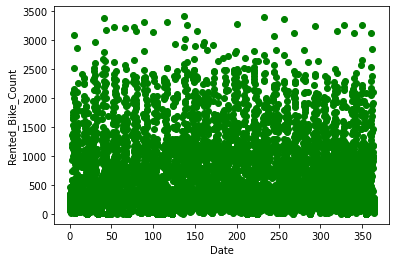

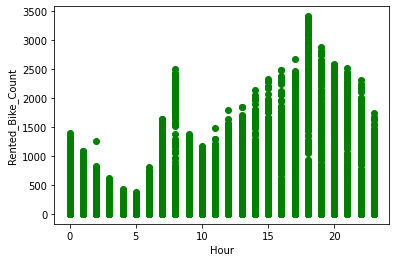

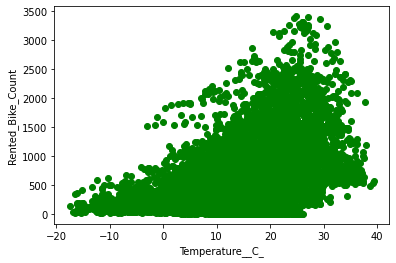

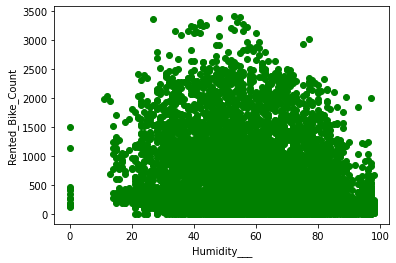

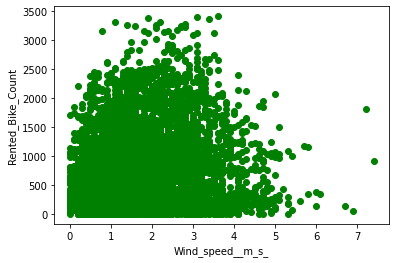

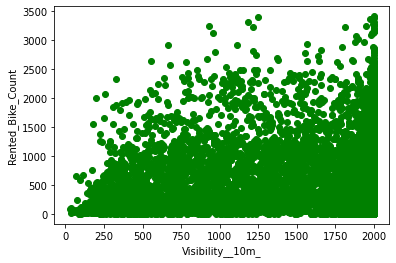

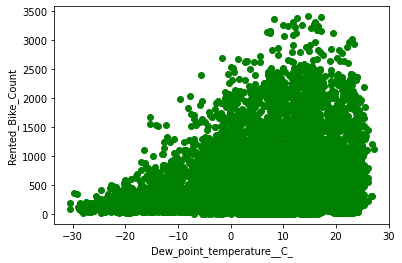

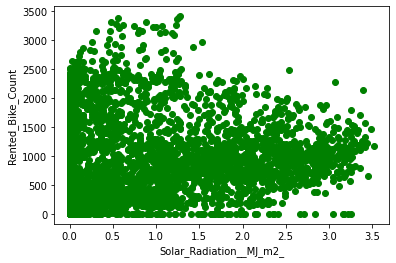

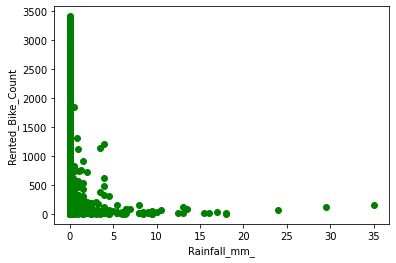

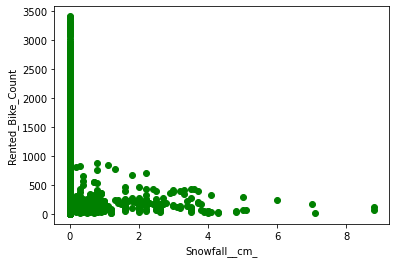

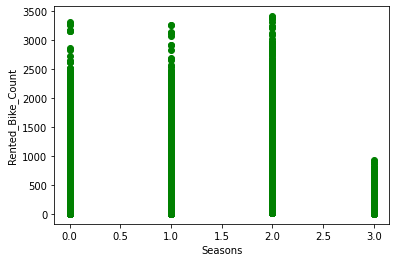

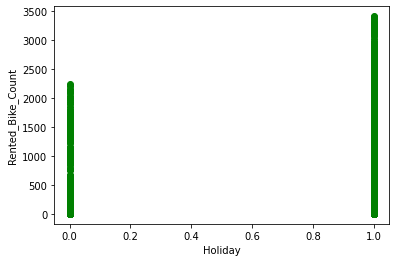

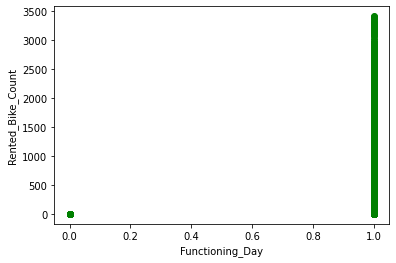

In [1277]:
show_plot(dr, label, kind='scatter')

In [1278]:
df_train = x_train.copy()
df_train[label] = y_train
df_val = x_valid.copy()
df_val[label] = y_valid
   
y_pred = dr.predict(x_test)
#print(y_pred)
#for val in y_pred:
#    print(val)
       
#show_predictions_lines(dr, x_test, y_test)
    
#show_plot(dr, label)